In [ ]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Comparison on multiple datasets

In [2]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
import sys
sys.path.append('./EXPLAN')
import explan
from utils import *

In [4]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [5]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [6]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [7]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    y_test_appended = np.concatenate([y_test,[1]])
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [8]:
shap.initjs()

In [9]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

In [10]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


Accuracy  model: 0.8435054773082942 for data_wine
----------- Model certainty for instance: 0.97 ---------------
Neighbourhood size: 127
Average distace of neighbourhood: 2.165402249574414.
Traiun sample size: 0.23289817232375978


 96%|=================== | 855/894 [00:17<00:00]       

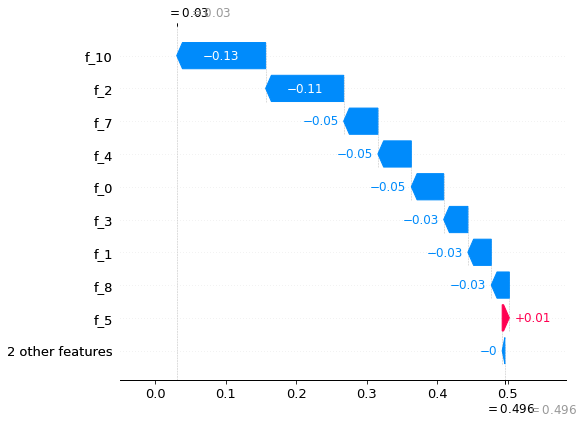

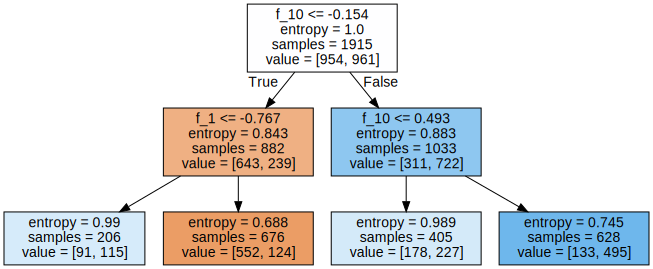

Fidelity  dectree: 0.7480314960629921
Accuracy  dectree: 0.7007874015748031
In fact using: 0.23289817232375978 samples from train set wiuth class balance: 0.43946188340807174
!!!!!!!!!!!!!!BEST f_2 for info_gain: 0.06108667129776535 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.1916637703814289 and pure_tg: 0.1916637703814289
!!!!!!!!!!!!!!BEST f_7 for info_gain: 0.07637680536665023 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_3 for info_gain: 0.23893780362525585 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_1 for info_gain: 0.0676900029557348 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_7 for info_gain: 0.09229812633793244 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_8 for info_gain: 0.06572633276563411 and pure_tg: 0


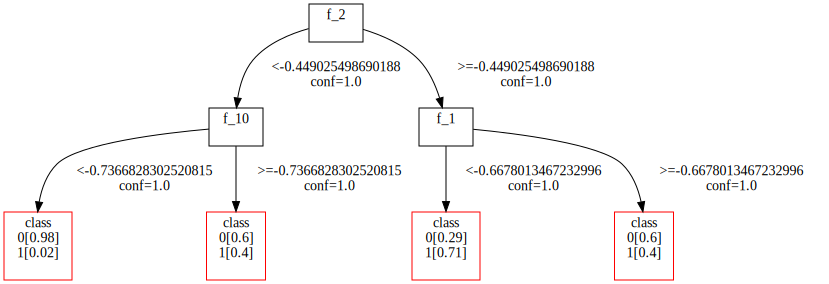

IF f_10  < -0.7366828302520815 AND f_2  < -0.449025498690188 THEN class = 0 # 0.9833333333333332



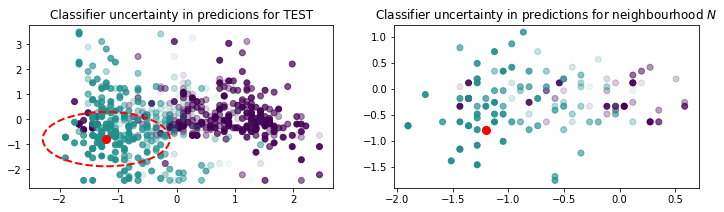

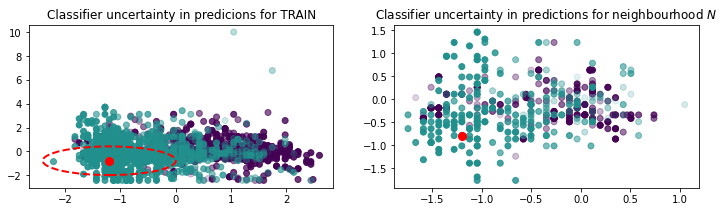

Fidelity  no proba: 0.6535433070866141
Accuracy  no proba: 0.7007874015748031
In fact using: 0.23289817232375978 samples from train set wiuth class balance: 0.43946188340807174
!!!!!!!!!!!!!!BEST f_2 for info_gain: 0.05642084539344849 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.15286366169132493 and pure_tg: 0.15286366169132493
!!!!!!!!!!!!!!BEST f_7 for info_gain: 0.030738355186570282 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_4 for info_gain: 0.17348280280455686 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_1 for info_gain: 0.05888046736103525 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_7 for info_gain: 0.09249871272933485 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.06663635725235872 and pure_tg: 0.06663635725235872


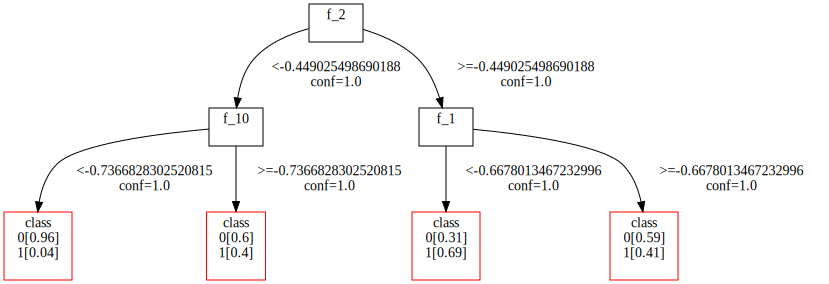

IF f_10  < -0.7366828302520815 AND f_2  < -0.449025498690188 THEN class = 0 # 0.9610000000000001



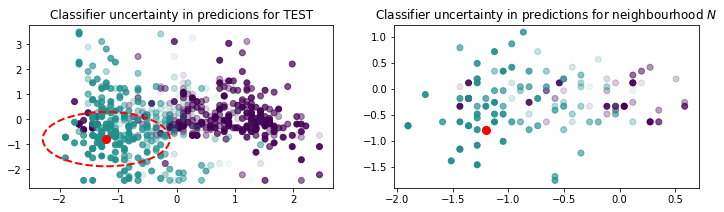

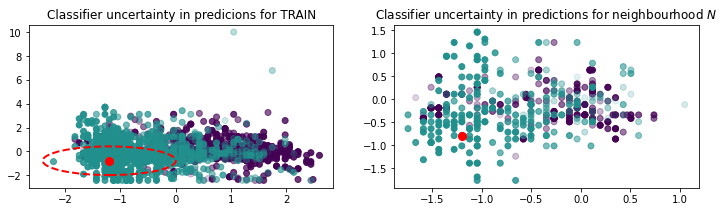

Fidelity  with proba: 0.6535433070866141
Accuracy  with proba: 0.7007874015748031
In fact using: 0.23289817232375978 samples from train set wiuth class balance: 0.43946188340807174


 97%|=================== | 863/892 [00:17<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.009149576447786134 and temp gain: 0.0008374023696138903
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.04775050477134546 and temp gain: 0.009210100257167552
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.05642084539344849 and temp gain: 0.007323543624093593
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.014149226722187325 and temp gain: 0.0018561956268900867
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.040984597603478945 and temp gain: 0.005780336343799941
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.0105642106513959 and temp gain: 0.0007213587808600444
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.023761100869742924 and temp gain: 0.002396181001569299
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.0332281774937232 and temp gain: 0.005374749357148875
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.02939747020386063 and temp gain: 0.002899277063559141
CS: A

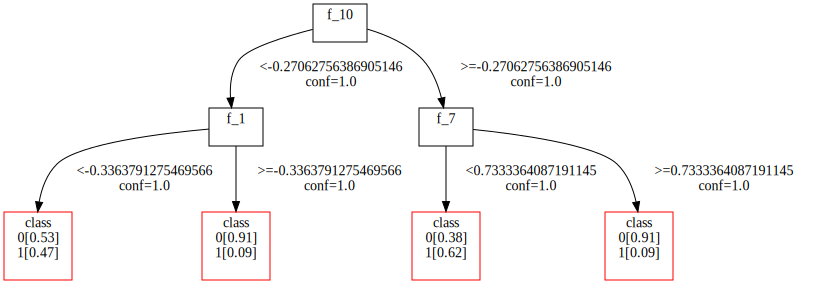

IF f_10  < -0.27062756386905146 AND f_1  < -0.3363791275469566 THEN class = 0 # 0.5251396648044692



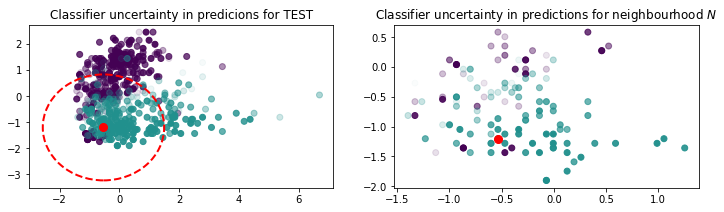

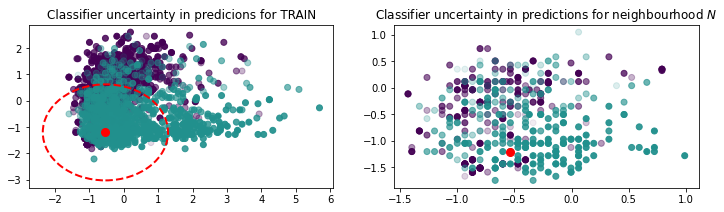

Fidelity  with shap: 0.8031496062992126
Accuracy  with shap: 0.7244094488188977
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 3312\n + load time: 0.028055 secs (24.65 MiB/s, 118.05 K rows/s)\n + indexing ... done\n + total time: 0.032593 secs (21.22 MiB/s, 101.61 K rows/s)\nBuilding 1 tree(s) on 3312 cases\n + tree(s) built\n + size: 5 depth: 2 nf: 2 time: 0.009362 secs\nPruning tree using training set\n + tree pruned\n + size: 5 depth: 2 nf: 2 time: 9e-06 secs\n'
Fidelity  EXPLAN: 0.7874015748031497
Accuracy  EXPLAN: 0.6929133858267716
Random expl e = {'f_10': '<=-0.270628'}
----------- Model certainty for instance: 0.59 ---------------
Neighbourhood size: 127
Average distace of neighbourhood: 1.876668680002532.
Traiun sample size: 0.2245430809399478


 98%|===================| 847/862 [00:18<00:00]        

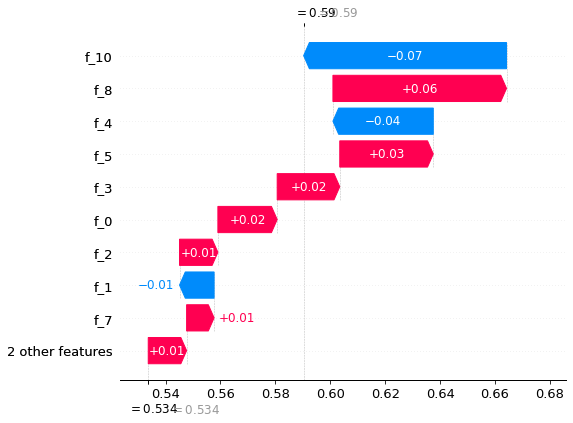

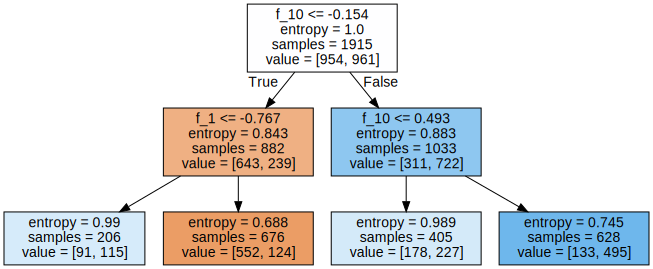

Fidelity  dectree: 0.7795275590551181
Accuracy  dectree: 0.6614173228346457
In fact using: 0.2245430809399478 samples from train set wiuth class balance: 0.541860465116279
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.08549920751322904 and pure_tg: 0.08549920751322904
!!!!!!!!!!!!!!BEST f_0 for info_gain: 0.11573620719823935 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_1 for info_gain: 0.12954611211804856 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_4 for info_gain: 0.03303271580171696 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_3 for info_gain: 0.03903799251557116 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_2 for info_gain: 0.08405864723798395 and pure_tg: 0


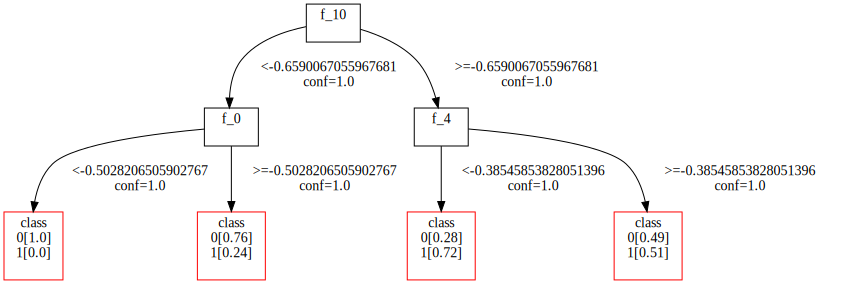

IF f_10  >= -0.6590067055967681 AND f_4  >= -0.38545853828051396 THEN class = 1 # 0.5082872928176796



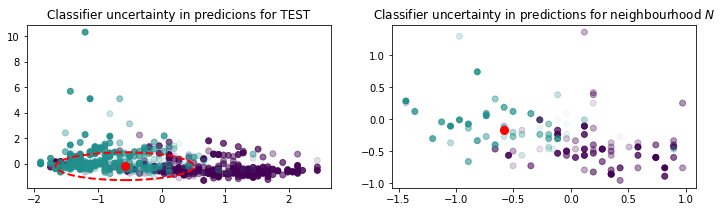

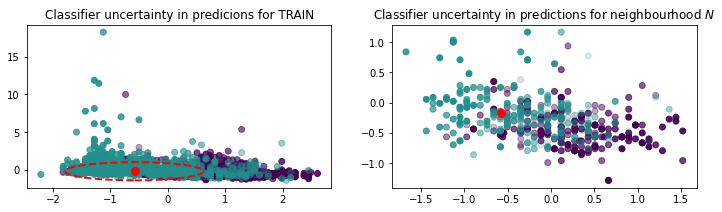

Fidelity  no proba: 0.7401574803149606
Accuracy  no proba: 0.5905511811023622
In fact using: 0.2245430809399478 samples from train set wiuth class balance: 0.541860465116279
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.07645440629174138 and pure_tg: 0.07645440629174138
!!!!!!!!!!!!!!BEST f_1 for info_gain: 0.06761836764932083 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_5 for info_gain: 0.08453081594159306 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.030454922248640104 and pure_tg: 0.030454922248640104
!!!!!!!!!!!!!!BEST f_4 for info_gain: 0.02939397352358919 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_0 for info_gain: 0.0365165599501277 and pure_tg: 0


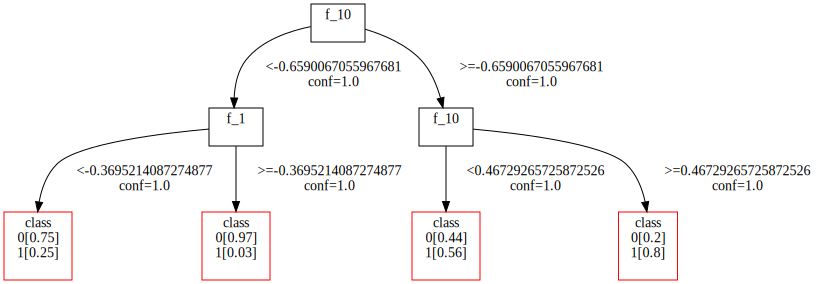

IF f_10  >= -0.6590067055967681 AND f_10  < 0.46729265725872526 THEN class = 1 # 0.5626056338028174



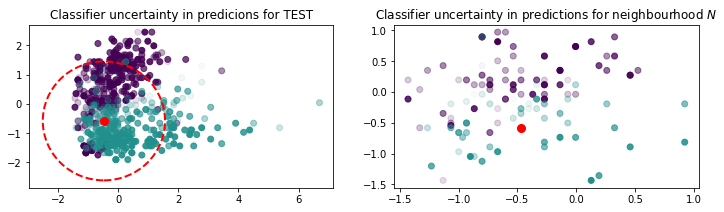

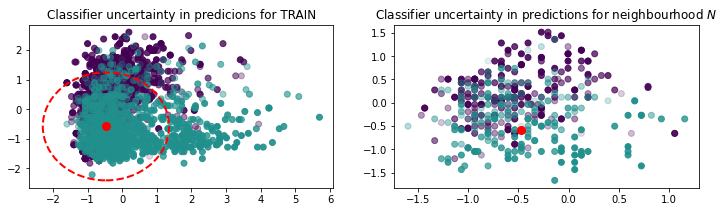

Fidelity  with proba: 0.7401574803149606
Accuracy  with proba: 0.5905511811023622
In fact using: 0.2245430809399478 samples from train set wiuth class balance: 0.541860465116279


 95%|=================== | 815/860 [00:18<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.02047108595962288 and temp gain: 0.001663554793489545
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.007541995997764617 and temp gain: 0.0007864017439581301
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.026209171897611072 and temp gain: 0.0028054368961211826
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.01140944846313674 and temp gain: 0.0010947043602607506
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.04893742368773002 and temp gain: 0.007061546729669272
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.012891174999288157 and temp gain: 0.0012533978850772227
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.01241222056863589 and temp gain: 0.0011093736227272095
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.052281716731117256 and temp gain: 0.01006123578231241
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.011806290653909812 and temp gain: 0.0010908663847607007


 94%|=================== | 687/728 [00:14<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.018138889038365802 and temp gain: 0.0015571704742162675
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.0059203352485318606 and temp gain: 0.0005779185638366385
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.0136406679659139 and temp gain: 0.0013585795115664055
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.01141310996562328 and temp gain: 0.001149877243911952
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.03013505247279258 and temp gain: 0.004111546330003919
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.012599296556718653 and temp gain: 0.0013510155203195868
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.014060957037543065 and temp gain: 0.0013937638771800156
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.029299963457039557 and temp gain: 0.0052668355089393725
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.0094477857087093 and temp gain: 0.0008698198401052468

 97%|=================== | 552/568 [00:11<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.014211663208343883 and temp gain: 0.0011919830691813475
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.005770976457873944 and temp gain: 0.0006879475052642716
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.010560487170059307 and temp gain: 0.0012163356778256453
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.008285403164742022 and temp gain: 0.0008139546689997779
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.02939397352358919 and temp gain: 0.004216265926966858
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.016891998471317837 and temp gain: 0.0019550786076950617
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.016949865777204587 and temp gain: 0.0017697526538045275
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.022857382309224072 and temp gain: 0.0042679828475135715
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.007049739155803203 and temp gain: 0.00071010547442

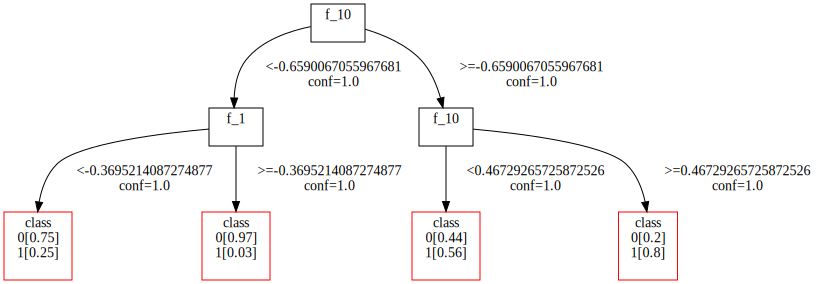

IF f_10  >= -0.6590067055967681 AND f_10  < 0.46729265725872526 THEN class = 1 # 0.5626056338028174



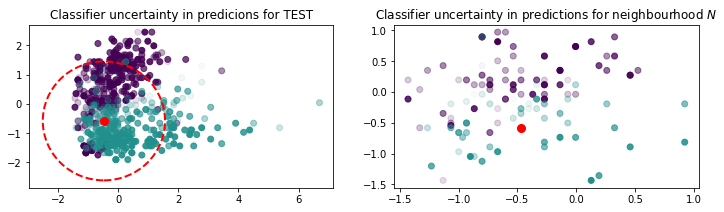

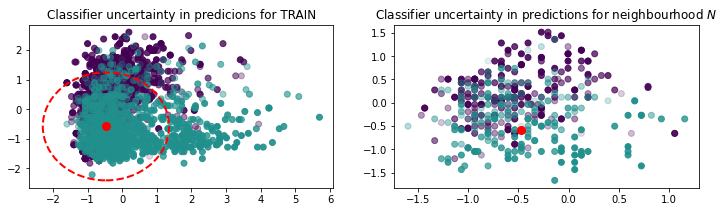

Fidelity  with shap: 0.7401574803149606
Accuracy  with shap: 0.5905511811023622
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 706\n + load time: 0.010904 secs (13.53 MiB/s, 64.74 K rows/s)\n + indexing ... done\n + total time: 0.01519 secs (9.71 MiB/s, 46.47 K rows/s)\nBuilding 1 tree(s) on 706 cases\n + tree(s) built\n + size: 3 depth: 1 nf: 1 time: 0.003323 secs\nPruning tree using training set\n + tree pruned\n + size: 3 depth: 1 nf: 1 time: 7e-06 secs\n'
Fidelity  EXPLAN: 0.8346456692913385
Accuracy  EXPLAN: 0.7007874015748031
Random expl e = {'f_10': '<=-0.192951'}
----------- Model certainty for instance: 0.85 ---------------
Neighbourhood size: 127
Average distace of neighbourhood: 2.2930698929492705.
Traiun sample size: 0.24281984334203655


100%|===================| 929/932 [00:20<00:00]        

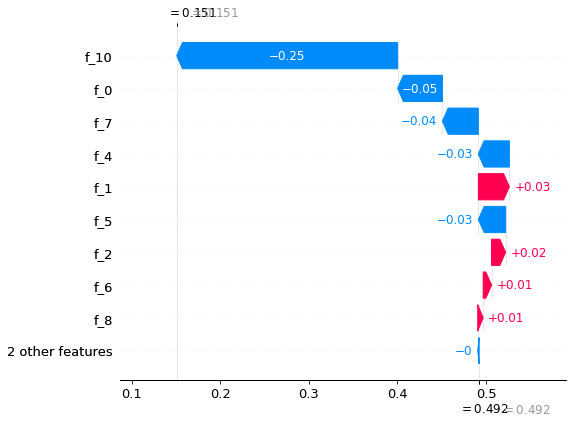

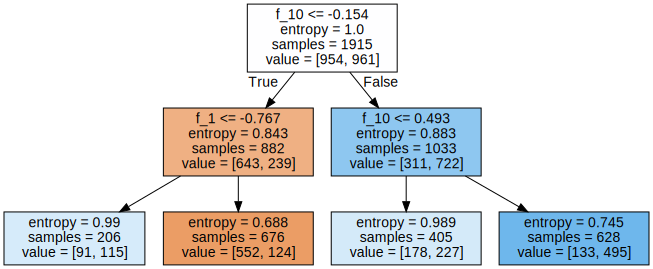

Fidelity  dectree: 0.7480314960629921
Accuracy  dectree: 0.7165354330708661
In fact using: 0.24281984334203655 samples from train set wiuth class balance: 0.46881720430107526
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.08839784960620123 and pure_tg: 0.08839784960620123
!!!!!!!!!!!!!!BEST f_1 for info_gain: 0.12232647270202512 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_0 for info_gain: 0.21599891577398256 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_9 for info_gain: 0.08202321338544953 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_0 for info_gain: 0.027752352877683295 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_2 for info_gain: 0.02719559660579629 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_3 for info_gain: 0.20597916043985953 and pure_tg: 0


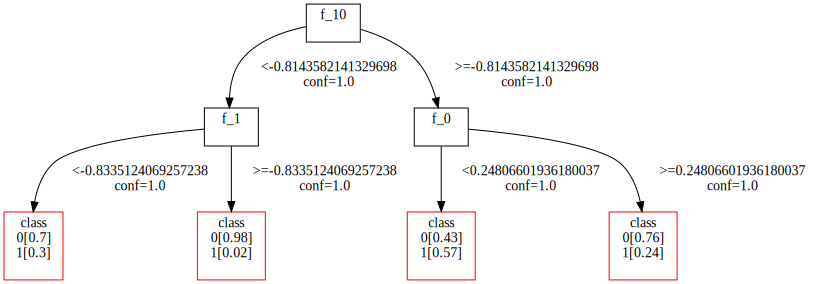

IF f_10  < -0.8143582141329698 AND f_1  < -0.8335124069257238 THEN class = 0 # 0.7037037037037037



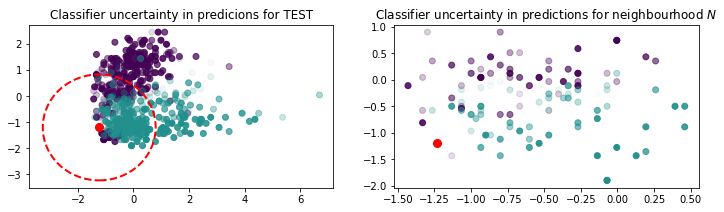

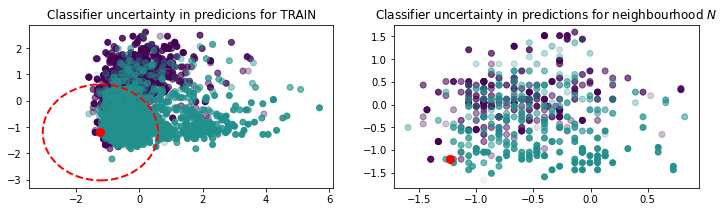

Fidelity  no proba: 0.6929133858267716
Accuracy  no proba: 0.6141732283464567
In fact using: 0.24281984334203655 samples from train set wiuth class balance: 0.46881720430107526
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.08509359884304502 and pure_tg: 0.08509359884304502
!!!!!!!!!!!!!!BEST f_1 for info_gain: 0.09480741148605026 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_1 for info_gain: 0.09344106644820949 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_9 for info_gain: 0.02797453308658146 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_4 for info_gain: 0.022309555801240832 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_6 for info_gain: 0.012351509019991602 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_7 for info_gain: 0.03477510512939486 and pure_tg: 0


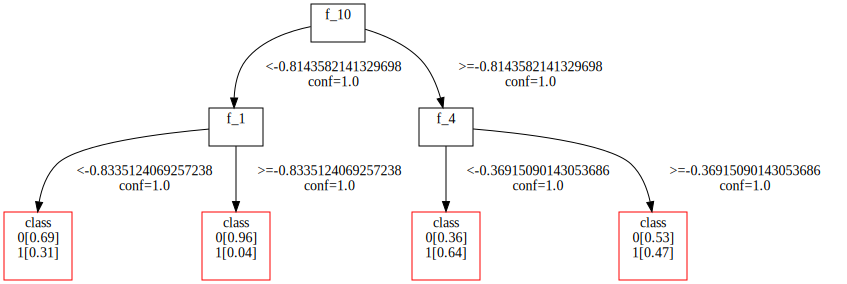

IF f_10  < -0.8143582141329698 AND f_1  < -0.8335124069257238 THEN class = 0 # 0.6925925925925926



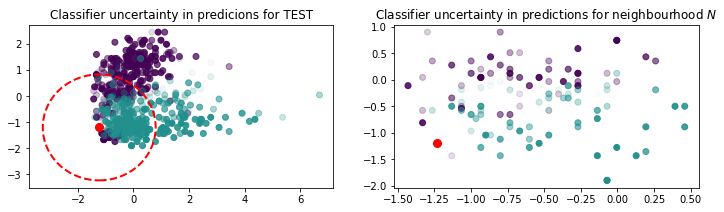

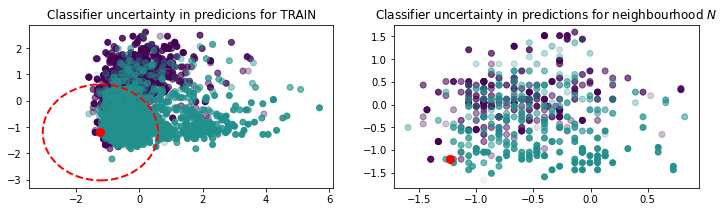

Fidelity  with proba: 0.7795275590551181
Accuracy  with proba: 0.6692913385826772
In fact using: 0.24281984334203655 samples from train set wiuth class balance: 0.46881720430107526


 96%|=================== | 895/930 [00:19<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.015069431400920097 and temp gain: 0.0011194458750616266
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.014363423282468313 and temp gain: 0.0017526068114358012
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.03487073687028608 and temp gain: 0.0038582458669944707
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.0038375872554682333 and temp gain: 0.0003760246320345013
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.047394424309050054 and temp gain: 0.006391554262397745
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.005643403318176032 and temp gain: 0.0005243062310487097
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.015888883546084864 and temp gain: 0.0012277356333017467
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.027884255390844936 and temp gain: 0.005017002595609223
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.014628348923030776 and temp gain: 0.00148835994074

 96%|=================== | 739/768 [00:16<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.01932938998923084 and temp gain: 0.0015049390237671684
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.012197645337052143 and temp gain: 0.0013339074585779773
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.012841706277456066 and temp gain: 0.0013640914622206689
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.010432459356747859 and temp gain: 0.0011898966112212483
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.022309555801240832 and temp gain: 0.0029231183102207286
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.00970862390980376 and temp gain: 0.0010906244718587364
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.010958787956861338 and temp gain: 0.0009499923745876883
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.012129984236670888 and temp gain: 0.0021217444898262157
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.011752613280418323 and temp gain: 0.00120515411355

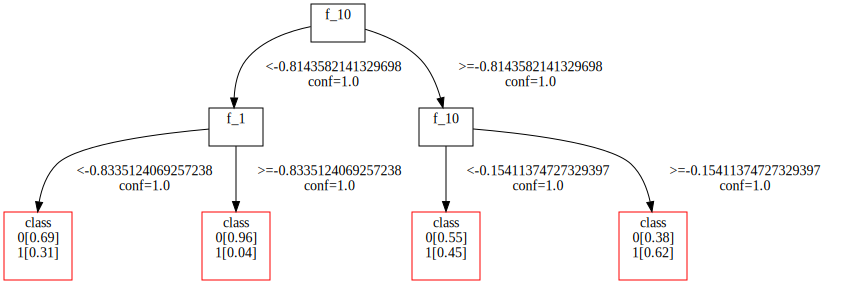

IF f_10  < -0.8143582141329698 AND f_1  < -0.8335124069257238 THEN class = 0 # 0.6925925925925926



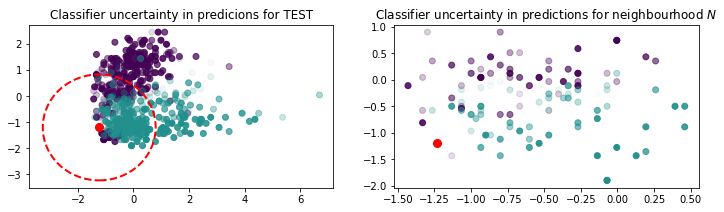

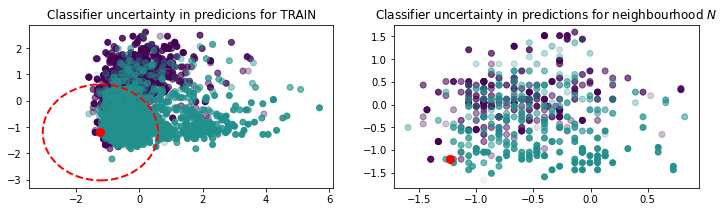

Fidelity  with shap: 0.84251968503937
Accuracy  with shap: 0.7480314960629921
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 802\n + load time: 0.017712 secs (9.45 MiB/s, 45.28 K rows/s)\n + indexing ... done\n + total time: 0.020317 secs (8.24 MiB/s, 39.47 K rows/s)\nBuilding 1 tree(s) on 802 cases\n + tree(s) built\n + size: 5 depth: 2 nf: 2 time: 0.003497 secs\nPruning tree using training set\n + tree pruned\n + size: 3 depth: 1 nf: 1 time: 8e-06 secs\n'
Fidelity  EXPLAN: 0.6692913385826772
Accuracy  EXPLAN: 0.6377952755905512
Random expl e = {'f_10': '<=0.117752'}
----------- Model certainty for instance: 0.89 ---------------
Neighbourhood size: 127
Average distace of neighbourhood: 4.952004827855062.
Traiun sample size: 0.23759791122715404


 99%|===================| 906/912 [00:18<00:00]        

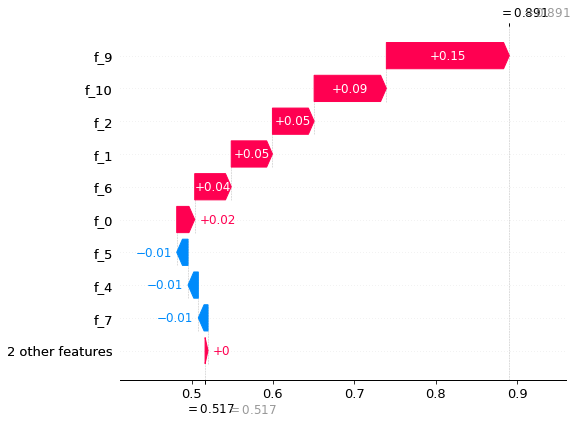

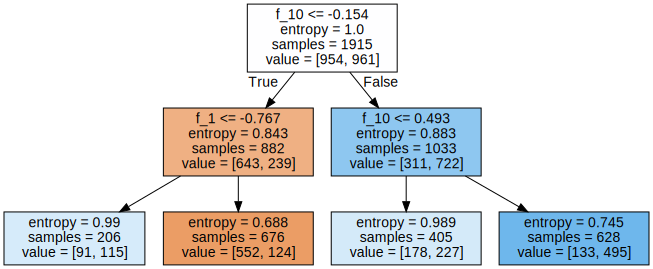

Fidelity  dectree: 0.7559055118110236
Accuracy  dectree: 0.6771653543307087
In fact using: 0.23759791122715404 samples from train set wiuth class balance: 0.5560439560439561
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.14555981079143987 and pure_tg: 0.14555981079143987
!!!!!!!!!!!!!!BEST f_4 for info_gain: 0.0997422782234707 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_0 for info_gain: 0.09486273410558477 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_9 for info_gain: 0.15051029792048554 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_2 for info_gain: 0.03688682494538176 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_5 for info_gain: 0.045716804766333885 and pure_tg: 0


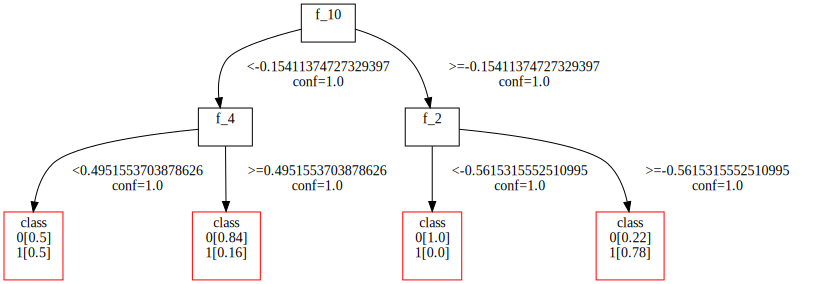

IF f_10  >= -0.15411374727329397 AND f_2  >= -0.5615315552510995 THEN class = 1 # 0.782608695652174



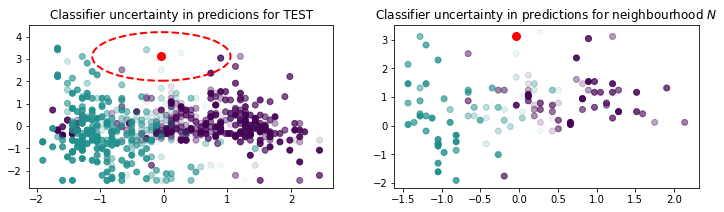

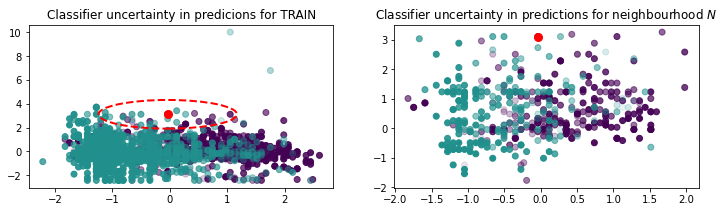

Fidelity  no proba: 0.6535433070866141
Accuracy  no proba: 0.5905511811023622
In fact using: 0.23759791122715404 samples from train set wiuth class balance: 0.5560439560439561
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.13125975530998746 and pure_tg: 0.13125975530998746
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.07760636698810641 and pure_tg: 0.07760636698810641
!!!!!!!!!!!!!!BEST f_1 for info_gain: 0.16370229423275373 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_1 for info_gain: 0.03335983786537311 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_2 for info_gain: 0.024874927767824073 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_3 for info_gain: 0.023832283664540377 and pure_tg: 0


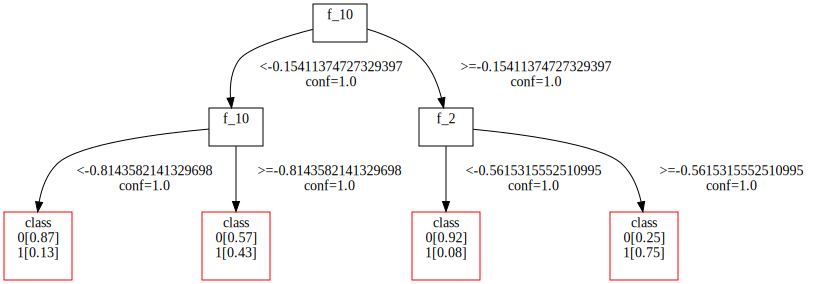

IF f_10  >= -0.15411374727329397 AND f_2  >= -0.5615315552510995 THEN class = 1 # 0.747608695652174



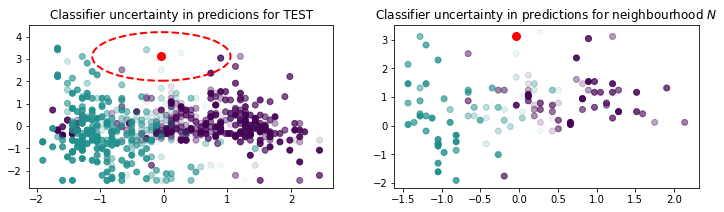

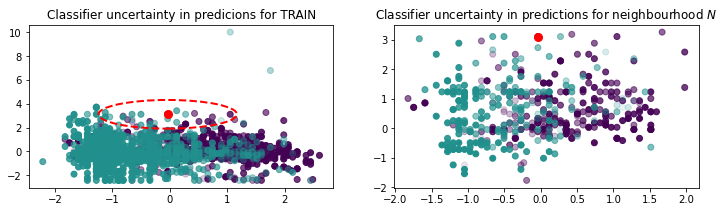

Fidelity  with proba: 0.8188976377952756
Accuracy  with proba: 0.7086614173228346
In fact using: 0.23759791122715404 samples from train set wiuth class balance: 0.5560439560439561


 96%|=================== | 878/910 [00:17<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.01326663169507758 and temp gain: 0.0007517838478764268
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.061177714224769586 and temp gain: 0.009520959241979016
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.05005921450557915 and temp gain: 0.004765730036829118
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.015438791595581258 and temp gain: 0.0009329698489463055
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.04225212868641948 and temp gain: 0.005042106242041548
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.014563219634630475 and temp gain: 0.0012151488354757978
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.012232023288333838 and temp gain: 0.0012740280578691745
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.046064584705120426 and temp gain: 0.006432473881216369
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.003437590611878094 and temp gain: 0.0001973251586727078

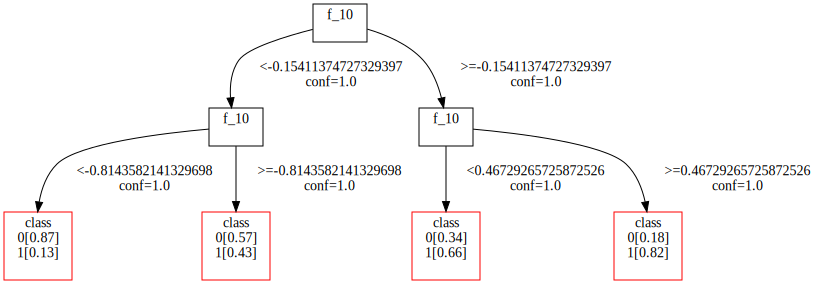

IF f_10  >= -0.15411374727329397 AND f_10  < 0.46729265725872526 THEN class = 1 # 0.6626829268292679



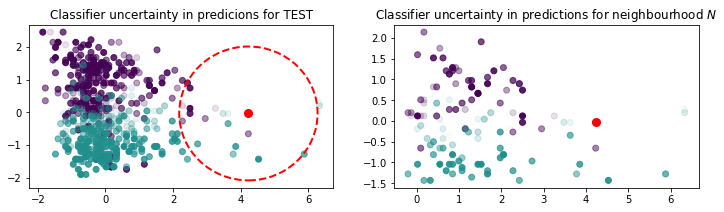

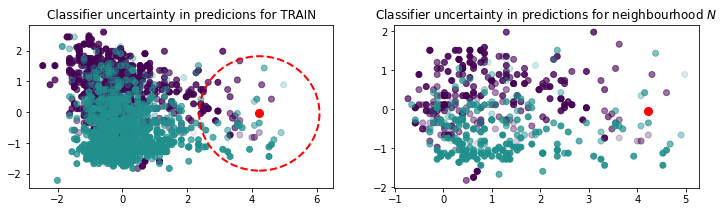

Fidelity  with shap: 0.8188976377952756
Accuracy  with shap: 0.7086614173228346
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 4030\n + load time: 0.028604 secs (29.36 MiB/s, 140.88 K rows/s)\n + indexing ... done\n + total time: 0.033118 secs (25.36 MiB/s, 121.68 K rows/s)\nBuilding 1 tree(s) on 4030 cases\n + tree(s) built\n + size: 7 depth: 2 nf: 3 time: 0.041256 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 2 nf: 3 time: 1.5e-05 secs\n'
Fidelity  EXPLAN: 0.8031496062992126
Accuracy  EXPLAN: 0.7244094488188977
Random expl e = {'f_10': '>-0.037600', 'f_2': '>-0.554723'}
----------- Model certainty for instance: 0.71 ---------------
Neighbourhood size: 127
Average distace of neighbourhood: 2.027433578715027.
Traiun sample size: 0.24490861618798956


 97%|=================== | 912/940 [00:19<00:00]       

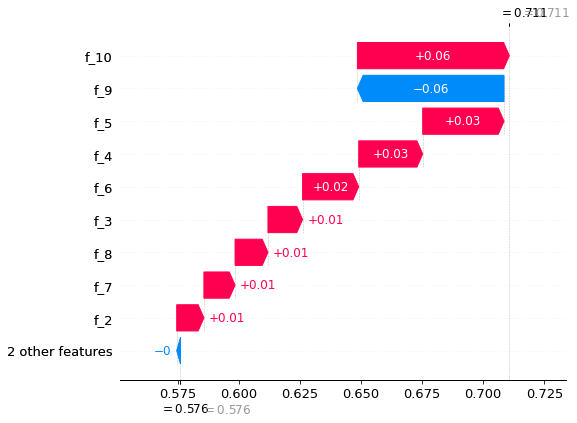

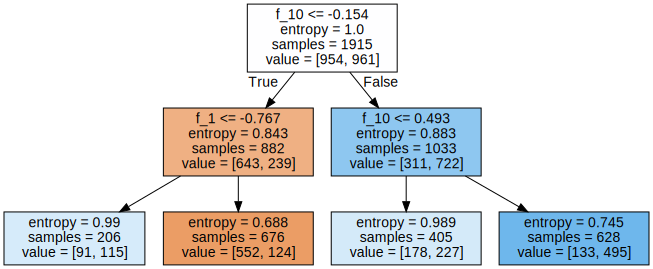

Fidelity  dectree: 0.8582677165354331
Accuracy  dectree: 0.7322834645669292
In fact using: 0.24490861618798956 samples from train set wiuth class balance: 0.5842217484008528
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.0547267913016638 and pure_tg: 0.0547267913016638
!!!!!!!!!!!!!!BEST f_6 for info_gain: 0.05045281053815065 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.04063146599438794 and pure_tg: 0.04063146599438794
!!!!!!!!!!!!!!BEST f_5 for info_gain: 0.05088772001125641 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_9 for info_gain: 0.08411362693589575 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_2 for info_gain: 0.051585272699274154 and pure_tg: 0


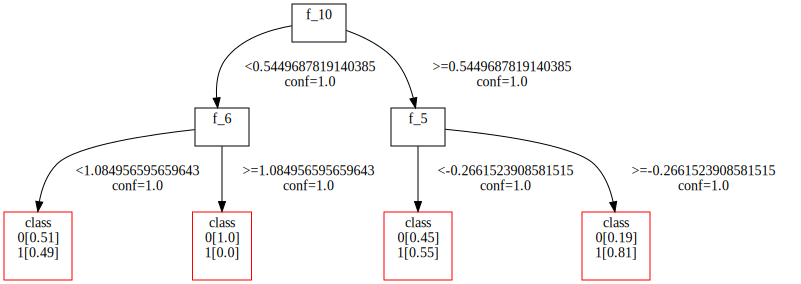

IF f_5  >= -0.2661523908581515 AND f_10  >= 0.5449687819140385 THEN class = 1 # 0.8137931034482758



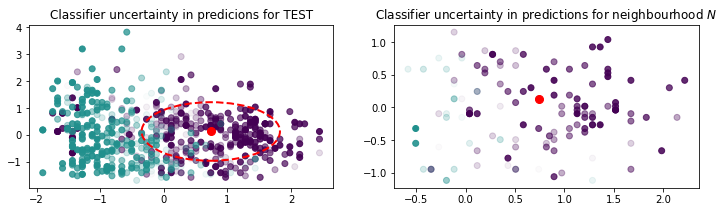

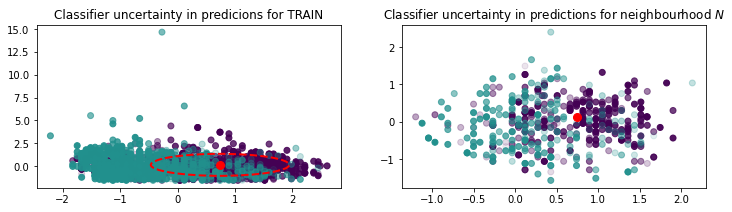

Fidelity  no proba: 0.7165354330708661
Accuracy  no proba: 0.6220472440944882
In fact using: 0.24490861618798956 samples from train set wiuth class balance: 0.5842217484008528
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.0529646713797336 and pure_tg: 0.0529646713797336
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.03306670121645072 and pure_tg: 0.03306670121645072
!!!!!!!!!!!!!!BEST f_1 for info_gain: 0.08341384527896556 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_6 for info_gain: 0.032691385925092686 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_5 for info_gain: 0.045461181659645966 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_5 for info_gain: 0.05016474328734466 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_6 for info_gain: 0.02939456761592829 and pure_tg: 0


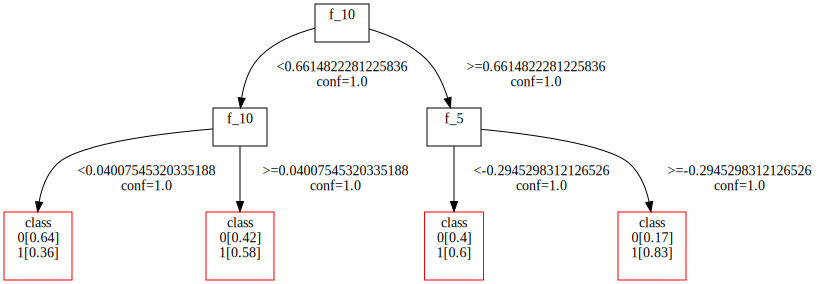

IF f_5  >= -0.2945298312126526 AND f_10  >= 0.6614822281225836 THEN class = 1 # 0.8335971223021579



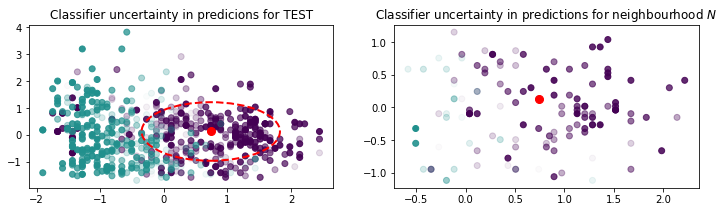

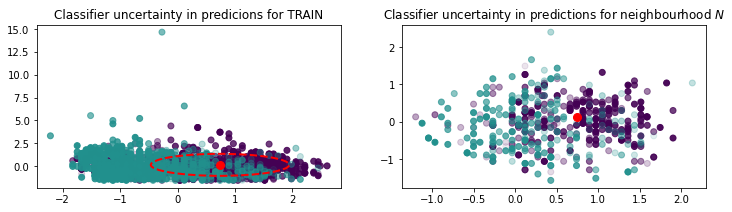

Fidelity  with proba: 0.889763779527559
Accuracy  with proba: 0.7322834645669292
In fact using: 0.24490861618798956 samples from train set wiuth class balance: 0.5842217484008528


 97%|=================== | 908/938 [00:18<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.009160392589413702 and temp gain: 0.0006460106629698828
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.006910288739430226 and temp gain: 0.0005658452793202998
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.01908110861568435 and temp gain: 0.0017406210100835956
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.011607803811054973 and temp gain: 0.0013896871722932805
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.027337968590231854 and temp gain: 0.0038854282119246742
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.022513019102687992 and temp gain: 0.0030522373405771444
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.012506912903322065 and temp gain: 0.0011765036319908394
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.02602388012694712 and temp gain: 0.004470861497074024
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.012584536391803347 and temp gain: 0.001096262830650

 99%|===================| 527/534 [00:11<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.021238407786389524 and temp gain: 0.0015514801309530744
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.023650070344654384 and temp gain: 0.0028528092006151616
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.016322244054838397 and temp gain: 0.0018365932814430137
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.013781830858987765 and temp gain: 0.0016520963090161703
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.025466623705418745 and temp gain: 0.0039241409208661876
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.012045407130533037 and temp gain: 0.0014474931784875626
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.022174509140068688 and temp gain: 0.0023103786108199624
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.009900726323927134 and temp gain: 0.0017894546543755147
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.017537853408402193 and temp gain: 0.001831634363

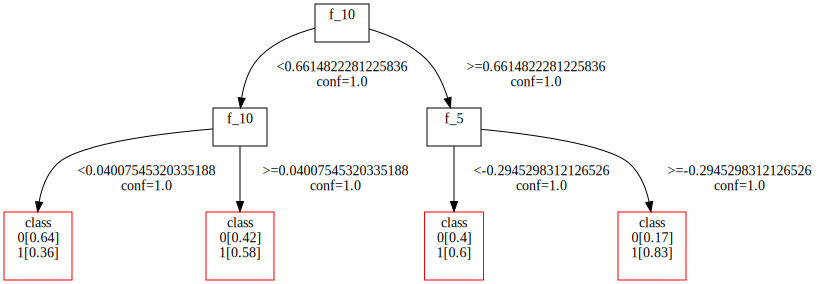

IF f_5  >= -0.2945298312126526 AND f_10  >= 0.6614822281225836 THEN class = 1 # 0.8335971223021579



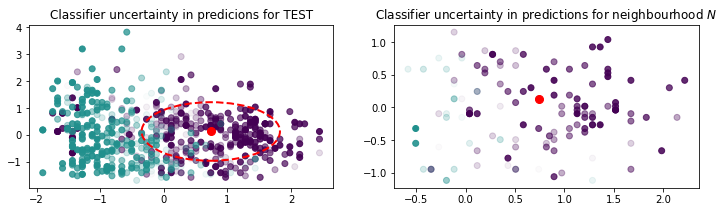

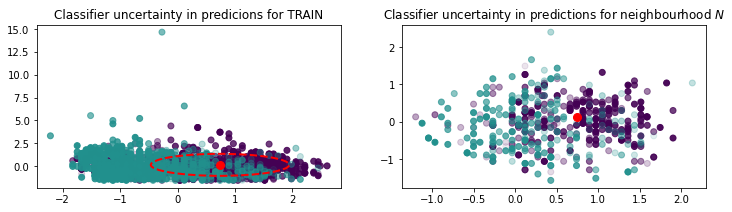

Fidelity  with shap: 0.889763779527559
Accuracy  with shap: 0.7322834645669292
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 11 class: 1 weight: 0 rows: 734\n + load time: 0.009947 secs (15.38 MiB/s, 73.79 K rows/s)\n + indexing ... done\n + total time: 0.012435 secs (12.3 MiB/s, 59.02 K rows/s)\nBuilding 1 tree(s) on 734 cases\n + tree(s) built\n + size: 5 depth: 2 nf: 2 time: 0.004769 secs\nPruning tree using training set\n + tree pruned\n + size: 5 depth: 2 nf: 2 time: 1e-05 secs\n'
Fidelity  EXPLAN: 0.7874015748031497
Accuracy  EXPLAN: 0.6456692913385826
Random expl e = {'f_1': '<=0.790456', 'f_0': '<=1.074042'}
Accuracy  model: 0.8812644564379337 for data_kdd_ipums_la_97-small
----------- Model certainty for instance: 1.0 ---------------
Neighbourhood size: 259
Average distace of neighbourhood: 3.128805972152954.
Traiun sampl

 99%|===================| 2600/2620 [01:01<00:00]        

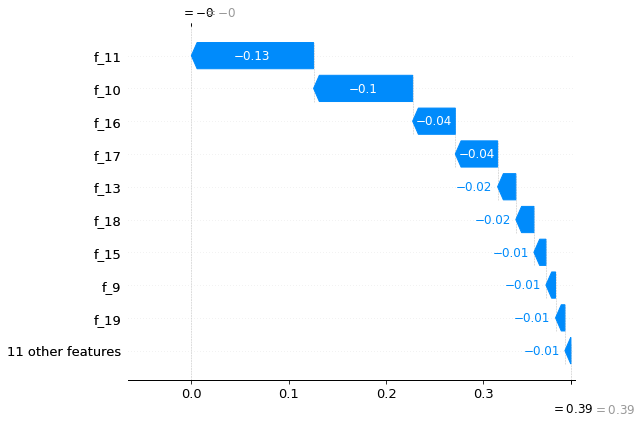

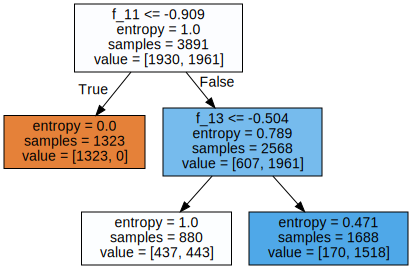

Fidelity  dectree: 1.0
Accuracy  dectree: 1.0
In fact using: 0.33641737342585454 samples from train set wiuth class balance: 0.3804430863254393
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.4026498833163582 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_13 for info_gain: 0.0869632626763821 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_9 for info_gain: 0.10612937441017256 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_16 for info_gain: 0.03396321361881638 and pure_tg: 0


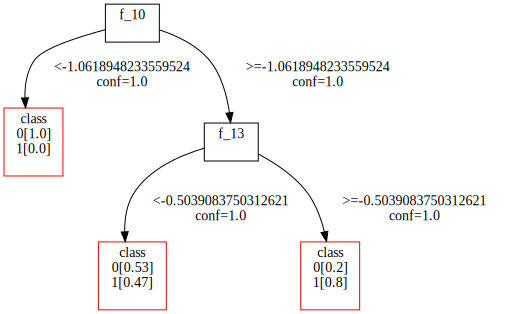

IF f_10  < -1.0618948233559524 THEN class = 0 # 1.0



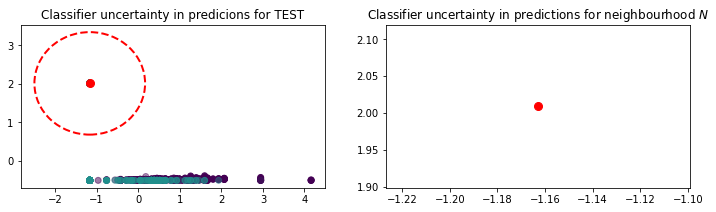

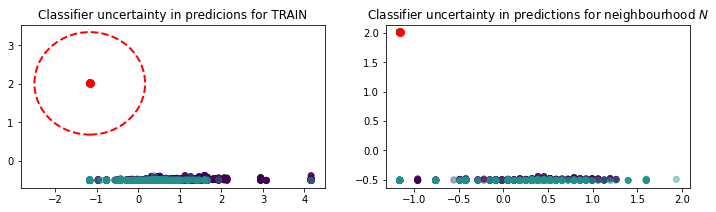

Fidelity  no proba: 1.0
Accuracy  no proba: 1.0
In fact using: 0.33641737342585454 samples from train set wiuth class balance: 0.3804430863254393
!!!!!!!!!!!!!!BEST f_10 for info_gain: 0.4101220648410574 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_13 for info_gain: 0.09526883547168197 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_9 for info_gain: 0.07236412795218672 and pure_tg: 0
!!!!!!!!!!!!!!BEST f_16 for info_gain: 0.01824802443017859 and pure_tg: 0


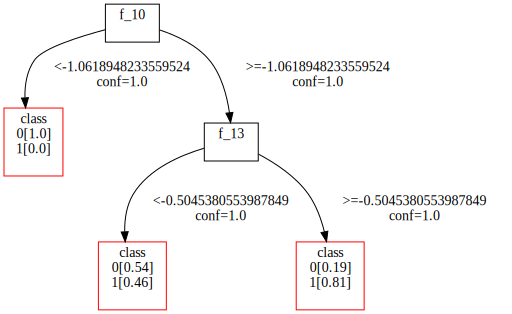

IF f_10  < -1.0618948233559524 THEN class = 0 # 0.9997383177570093



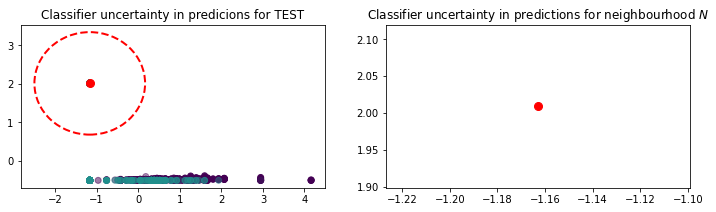

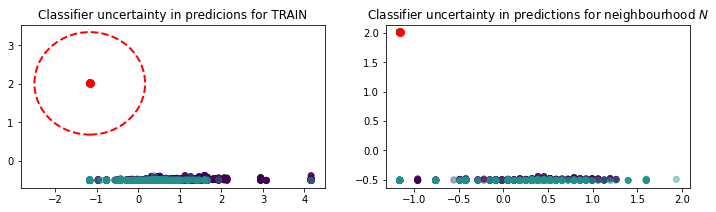

Fidelity  with proba: 1.0
Accuracy  with proba: 1.0
In fact using: 0.33641737342585454 samples from train set wiuth class balance: 0.3804430863254393


100%|===================| 2606/2618 [00:59<00:00]        

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.0021861992102921723 and temp gain: 4.26664369958662e-05
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.004074238938159502 and temp gain: 0.0001203452355646486
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.021276064986659127 and temp gain: 0.001082096737397697
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.07880203366525029 and temp gain: 0.0008781825308242153
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.07239407799880593 and temp gain: 0.00124012082205357
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.004711736454271032 and temp gain: 5.852216285431168e-06
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.0103337644106406 and temp gain: 3.3129405865558156e-05
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.0103337644106406 and temp gain: 2.338656518618832e-05
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.06344562748228688 and temp gain: 0.0006323983070428964
C

 99%|===================| 1534/1548 [00:41<00:00]        

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.004912019441708271 and temp gain: 0.00016404511998255398
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.008840487506418748 and temp gain: 0.000628287446220496
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.007271866618178691 and temp gain: 0.0007028408603641145
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 9.621190279829328e-05 and temp gain: 2.0711969519595886e-06
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.003382853970644417 and temp gain: 0.00013079809503258342
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 9.188674542026654e-06 and temp gain: 9.54034867290297e-09
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.004062979231255537 and temp gain: 1.2823071470256954e-05
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.004062979231255537 and temp gain: 8.109792970728553e-06
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.001329901410211054 and temp gain: 2.18744509

 94%|=================== | 640/682 [00:15<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.00589424708881936 and temp gain: 0.00027273074083546643
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.02277846672436823 and temp gain: 0.0017665018686642492
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.01435818256192134 and temp gain: 0.0016920656994703215
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.022684936953675572 and temp gain: 0.001019670032282778
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.019242535684865447 and temp gain: 0.0010660459989444745
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.0024319361734300715 and temp gain: 6.610017941676382e-06
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.009031212179560932 and temp gain: 6.423337346020993e-05
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.009031212179560932 and temp gain: 4.1227762744757915e-05
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.014197585829485049 and temp gain: 0.0004800199728

 97%|=================== | 836/866 [00:18<00:00]       

CS: AFTER WITH: ATT: f_0 Pure tem obtained from cspC: 0.0023879299928193376 and temp gain: 6.260443076695833e-05
CS: AFTER WITH: ATT: f_1 Pure tem obtained from cspC: 0.0023822465662233228 and temp gain: 0.00020883722669807646
CS: AFTER WITH: ATT: f_2 Pure tem obtained from cspC: 0.0019179011129195622 and temp gain: 0.00017170927870638035
CS: AFTER WITH: ATT: f_3 Pure tem obtained from cspC: 0.00010534057803579522 and temp gain: 1.4647336553357466e-06
CS: AFTER WITH: ATT: f_4 Pure tem obtained from cspC: 0.0014039623975263815 and temp gain: 4.856837177621663e-05
CS: AFTER WITH: ATT: f_5 Pure tem obtained from cspC: 0.0007801830159533951 and temp gain: 1.3754402724846303e-06
CS: AFTER WITH: ATT: f_6 Pure tem obtained from cspC: 0.001249169458690691 and temp gain: 2.3567997693766183e-06
CS: AFTER WITH: ATT: f_7 Pure tem obtained from cspC: 0.001249169458690691 and temp gain: 2.6917129350895115e-06
CS: AFTER WITH: ATT: f_8 Pure tem obtained from cspC: 0.0002156598672916621 and temp gain: 

In [ ]:
nac_data  = []
fid_data = []
imp_fid_data=[]
rs=42
init_fraction=0.2
directory = './data/numerical_only/balanced'
#directory = './data/num_and_cat/balanced'
up=True
depth = 2
SAMPLE_SIZE=5
show=True
ismpl=True
synthetic = False
density_sampling=True
radius_sampling=False#True
oversampling=False
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
representative=LUX.REPRESENTATIVE_CENTROID
categorical_indicator=None

for num_and_cat in  os.listdir(directory):
    #(data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    features = [f'f_{i}' for i in range(0,data.shape[1])]
    if directory =='./data/numerical_only/balanced':
        categorical_indicator=[False]*len(features)
    continuous_indicator = np.logical_not(categorical_indicator)
    target = 'class'
    df = pd.DataFrame(data,columns=features,dtype=float)
    sc = StandardScaler()
    df.loc[:,df[features].columns[continuous_indicator]]=sc.fit_transform(df[df[features].columns[continuous_indicator]])#normalize(df, axis=0)#sc.fit_transform(df)
    df[target] = y
    
    if synthetic: 
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=8, 
                                              n_informative=6, n_redundant=2, n_repeated=0, n_clusters_per_class=3,
                                              n_classes=2)
        features = [f'x{i}' for i in range(1,X.shape[1]+1)]
        df = pd.DataFrame(X, columns=features)
        df[target] = y
    
    if len(df) >6000:
        continue
        fraction = 1000.0/len(df)
        if len(df.columns) > 12:
            continue
    else:
        fraction = init_fraction
        
    
    
    ## train xgboost, 
    train, test = train_test_split(df, random_state=rs)
    clf = RandomForestClassifier(random_state=rs,n_jobs=-1)
    #clf = svm.SVC(probability=True,random_state=rs)
    clf.fit(train[features],train[target])
    model_score = accuracy_score(clf.predict(test[features]),test[target])
    print(f'Accuracy  model: {model_score} for {num_and_cat}')
    
    
    for explain_instance in test[features].sample(SAMPLE_SIZE,random_state=rs).values:
        explain_instance=np.array(explain_instance).reshape(1,-1)
        #explain_instance = test[features].sample(1).values#.astype('f8')    
        
        instance_certainty_clf = np.max(clf.predict_proba(explain_instance))
        print(f'----------- Model certainty for instance: {np.max(clf.predict_proba(explain_instance))} ---------------')
    
        # distances = sklearn.metrics.pairwise_distances(test[features], explain_instance)
        # pd.DataFrame(distances).hist()
        # plt.show()
        # _,borders = np.histogram(distances)
        # idxs,_ = np.where(distances<=borders[2])
        # dfneigh = test.iloc[idxs]
        # print(f'Neighbourhood size: {len(dfneigh)}')
        
        n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
        nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
        nn.fit(test[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh= test.iloc[ids_c.ravel()]
        
        
        
        ##############for testing dectree on the bbox sample################
        lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  
                  node_size_limit = 2, grow_confidence_threshold = 0)
        X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance],
                                                  X_importances = None, exclude_neighbourhood=False, class_names=[0,1],
                                                  use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                                 representative=representative,density_sampling=density_sampling)
        print(f'Traiun sample size: {len(X_train_sample)/len(train)}')
        ###################################################################
        #shap on this sample
        #append pint as a first element and plot force plot
        X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
        explainer = shap.Explainer(clf, X_shap)
        shap_values = explainer.shap_values(X_shap,check_additivity=False)
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0,:],feature_names = features )
        
        #take N most relevant features and focus only on these when building explanations
        vals= np.abs(shap_values).mean(0).mean(0)
        feature_importance = pd.DataFrame(list(zip(features,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        shapfeatures = feature_importance.head(n=10) ## see if features used in predicting the explain instance are among the top oN of shap-returned values (LOCALLY) -- do the same with global SHAP values

        data = Data.parse_dataframe(dfneigh[features+[target]],categorical=categorical_indicator)
        clf_dtree = DecisionTreeClassifier(random_state=rs,max_depth=depth,criterion='entropy')
        clf_dtree.fit(train[features],clf.predict(train[features]))

        if show:
            graph = Source(tree.export_graphviz(clf_dtree, out_file=None
               , feature_names=features, 
                                                #class_names=['0', '1'] ,
                filled = True,max_depth=depth))
            display(SVG(graph.pipe(format='svg')))

        dectree_score =  accuracy_score(clf_dtree.predict(dfneigh[features]),clf.predict(dfneigh[features]))
        print(f'Fidelity  dectree: {dectree_score}')
        dectree_score_acc =  accuracy_score(clf_dtree.predict(dfneigh[features]),dfneigh[target])
        print(f'Accuracy  dectree: {dectree_score_acc}')
       

        #explain xgboost without proba, 
        lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0)
        lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up,oversampling=oversampling,representative=representative,
                radius_sampling=radius_sampling, inverse_sampling=ismpl ,density_sampling=density_sampling, n_jobs=-1,
               uncertain_entropy_evaluator=uncertain_entropy_evaluator)

        #calculate decision tree score over this dataset
        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
            
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
        if synthetic and X_train_sample.shape[1] == 2:
            decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)
        

        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_pure = accuracy_score(predictions, clf.predict(dfneigh[features]))
        print(f'Fidelity  no proba: {ac_score_pure}')
        ac_score_pure_acc =  accuracy_score(predictions,dfneigh[target])
        print(f'Accuracy  no proba: {ac_score_pure_acc}')
        
        ats_no_proba = [a.get_name() for a in lux.uid3.tree.get_attributes() if a not in [target]]
        importance_gain_noproba = shapfeatures[shapfeatures['col_name'].isin(ats_no_proba)]['feature_importance_vals'].sum()/len(ats_no_proba)

        #with proba, 
        lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
        lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up, 
                uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,representative=representative,
                radius_sampling=radius_sampling,inverse_sampling= ismpl,density_sampling=density_sampling, n_jobs=-1)
        
        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
            
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
       # decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)


        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_proba = accuracy_score(predictions, clf.predict(dfneigh[features]))
        print(f'Fidelity  with proba: {ac_score_proba}')
        ac_score_proba_acc =  accuracy_score(predictions,dfneigh[target])
        print(f'Accuracy  with proba: {ac_score_proba_acc}')

        ats_with_proba = [a.get_name() for a in lux.uid3.tree.get_attributes() if a not in [target]]
        importance_gain_with_proba = shapfeatures[shapfeatures['col_name'].isin(ats_with_proba)]['feature_importance_vals'].sum()/len(ats_with_proba)
        
        lux = LUX(classifier = clf,predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
        lux.fit(train[features], train[target], 
                X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
                instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
                use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )

        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
        #decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)

        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_shap = accuracy_score(predictions, clf.predict(dfneigh[features]))
        print(f'Fidelity  with shap: {ac_score_shap}')
        ac_score_shap_acc = accuracy_score(predictions, dfneigh[target])
        print(f'Accuracy  with shap: {ac_score_shap_acc}')
        
        ats_shap= [a.get_name() for a in lux.uid3.tree.get_attributes() if a not in [target]]
        importance_gain_shap = shapfeatures[shapfeatures['col_name'].isin(ats_shap)]['feature_importance_vals'].sum()/len(ats_shap)
        
        myds = prepare_ds(train,discrete=categorical_indicator)
        X, y = myds['X'], myds['y']
        instance2explain = explain_instance.ravel()

        # EXPLAN hyper-parameters
        N_samples = 3000#n_neighbors
        tau = 250#int(n_neighbors)/len(np.unique(df[target])

        # Explaining instance x using EXPLAN
        exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
                                                   clf,
                                                   myds,
                                                   N_samples=N_samples,
                                                   tau=tau,depth=depth)

        explan_y=pyyadt.predict(info_EXPLAN['C'], dfneigh[features+[target]].to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])
        ac_score_explan = accuracy_score(explan_y[0], clf.predict(dfneigh[features]))
        print(f'Fidelity  EXPLAN: {ac_score_explan}')
        ac_score_explan_acc = accuracy_score(explan_y[0], dfneigh[target])
        print(f'Accuracy  EXPLAN: {ac_score_explan_acc}')
        print('Random expl e = %s' % exp_EXPLAN[1])
        
        ats_explan = list(exp_EXPLAN[1].keys())
        importance_gain_explan = shapfeatures[shapfeatures['col_name'].isin(ats_explan)]['feature_importance_vals'].sum()/len(ats_explan)

        imp_fid_data.append([num_and_cat,num_and_cat,importance_gain_noproba, importance_gain_with_proba, importance_gain_shap, importance_gain_explan])
        fid_data.append([num_and_cat,num_and_cat,instance_certainty_clf,ac_score_pure,ac_score_proba,ac_score_shap, model_score, dectree_score,ac_score_explan,shapfeatures])
        nac_data.append([num_and_cat,num_and_cat,instance_certainty_clf,ac_score_pure_acc,ac_score_proba_acc,ac_score_shap_acc, model_score, dectree_score_acc,ac_score_explan_acc,shapfeatures])
    ## save results        
    

<AxesSubplot:xlabel='dataset'>

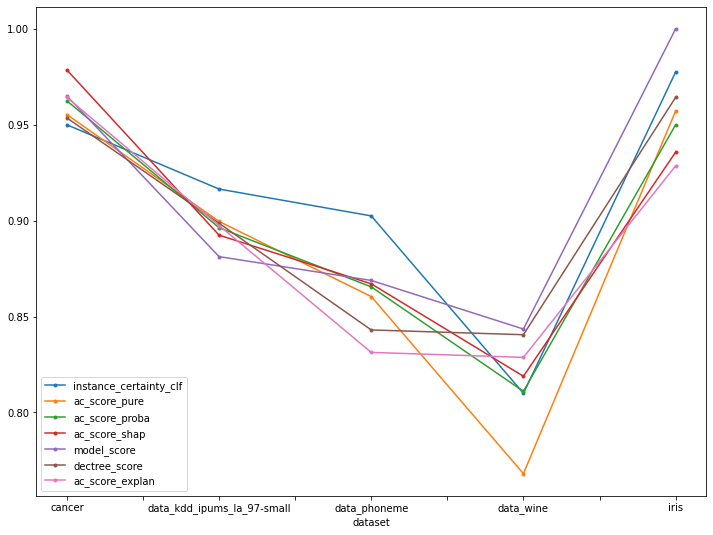

In [ ]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_pure','ac_score_proba','ac_score_shap', 'model_score', 'dectree_score','ac_score_explan','shapfeatures'])
results_fid.groupby('dataset').mean().plot(style='.-',figsize=(12,9))
                       

In [ ]:
results_fid.mean()

<AxesSubplot:>

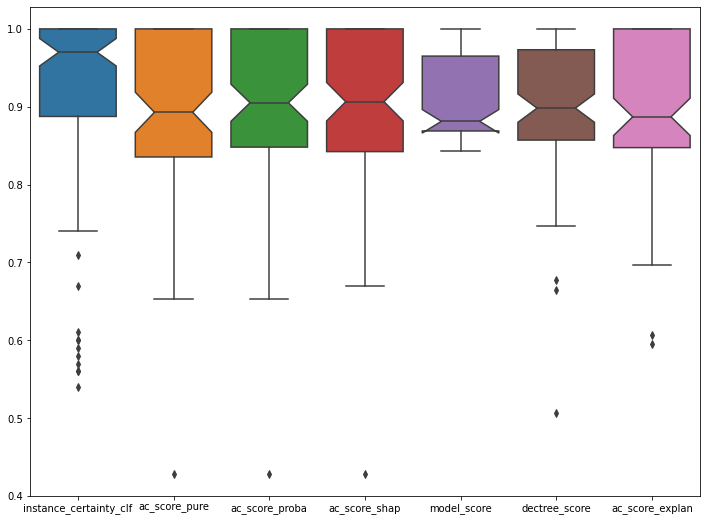

In [31]:
#with shap only
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_fid,notch=True,ax=ax)

In [ ]:
results_imp_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','importance_gain_noproba', 'importance_gain_with_proba', 'importance_gain_shap', 'importance_gain_explan'])
results_imp_fid.groupby('dataset').mean().plot(style='.-',figsize=(12,9))
                       

In [ ]:
#with shap only
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_imp_fid,notch=True,ax=ax)

In [ ]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_pure','ac_score_proba','ac_score_shap', 'model_score', 'dectree_score'])
results_fid[['ac_score_shap', 'dectree_score','ac_score_proba']].plot(figsize=(12,9))

In [ ]:
results.to_csv('results_background_subset_set_real_f02n02.csv',index=False)